In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data

In [2]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [3]:
readRDS = robjects.r['readRDS']
dfs = readRDS('../data/dfs_filtered.rds')
dfs = pandas2ri.ri2py_vector(dfs)

In [4]:
df = dfs[0]

In [5]:
df.head()

,node_status,grade,tumor_size,survival_time,event,age,chemo,hormonal,radiation,stage,...,PAPSS2,CEP43,PCDHGA6,TAAR2,TMEM107,TM4SF19,STIL,MCM10,SEPTIN1,THOC3
274,1,3,1.5,10.000000,0.0,66.83,0,1,1,3,...,8.189176,6.508291,5.277828,5.378119,5.611919,5.403250,6.785248,6.068219,5.515154,7.492707
374,0,2,2.3,8.436111,0.0,60.77,0,1,1,2,...,9.414757,6.576653,5.382906,5.284577,5.473033,5.159056,6.469590,5.456739,5.430287,8.005263
486,1,2,1.4,8.547222,0.0,56.34,0,1,1,2,...,8.760117,6.206183,5.435107,5.356615,6.486817,5.222540,6.199694,5.303843,5.736608,7.545293
455,0,2,1.8,9.550000,0.0,58.08,0,1,0,1,...,9.309239,6.691422,5.390576,5.275552,6.654679,5.216872,6.378397,5.732758,5.496054,7.195014
166,0,3,1.1,7.177778,0.0,62.70,0,1,1,1,...,6.854274,6.905754,5.383921,5.286581,5.823286,5.547659,7.076835,6.132341,5.275281,7.732057


## Separate into clinical and expression dataframes

In [6]:
first_gene = "EEF1A1"
k = df.columns.get_loc(first_gene)
C = df.iloc[:,:k]
E = df.iloc[:,k:]

## Normalize and reshape expressions

In [76]:
from math import log, e

In [686]:
N = int(np.sqrt(E.shape[1]))

In [417]:
def spin(v): 
    s = lambda x: 1 if x==1 else -1
    return list(map(s, v))

In [1093]:
# def scale(l, factor=255): return np.int64(factor*(l -np.min(l))/(np.max(l)-np.min(l)))
def scale(col): return spin(np.int64(col>(col.median())))

In [ ]:

# Create correlation matrix
corr_matrix = E.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
E.drop(to_drop, axis=1, inplace=True)

In [1094]:
E = E.iloc[:,:(N*N)]
E_scaled = E.apply(scale, axis=0, result_type="expand")

In [1095]:
E_scaled = E_scaled.replace(-1,0)

In [1096]:
E_scaled_np = E_scaled.values

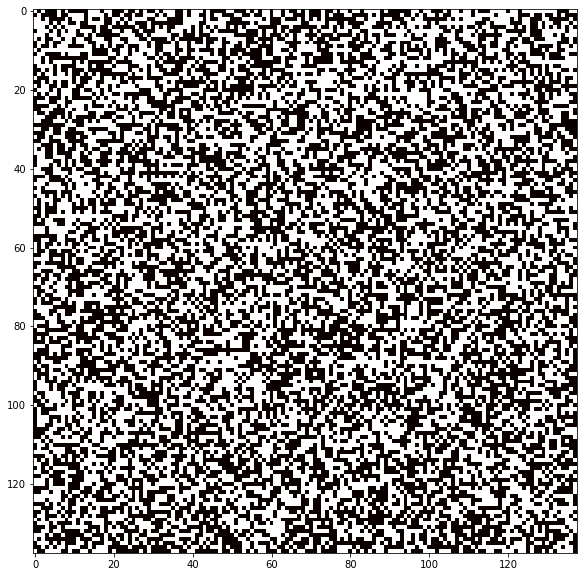

In [1097]:
img = E_scaled_np[0,:].reshape((N,N))
plt.figure(figsize=(10,10));
plt.imshow(img, cmap="hot");
##plt.colorbar();

In [667]:
from scipy.ndimage import measurements

In [669]:
from pylab import *

In [1071]:
def entropy(data, base=None):
    vc = pd.Series(data).value_counts(normalize=True, sort=False)
    base = e if base is None else base
    return -(vc * np.log(vc)/np.log(base)).sum()

In [1072]:
def calcEnergy(config):
    '''
    Energy of a given configuration
    '''
    energy = 0 
    
    for i in range(len(config)):
        for j in range(len(config)):
            S = config[i,j]
            nb = config[(i+1)%N, j] + config[i,(j+1)%N] + config[(i-1)%N, j] + config[i,(j-1)%N]
            energy += -nb*S
    return energy/(N**2)  # to compensate for over-counting

def calcMag(config):
    '''
    Magnetization of a given configuration
    '''
    mag = np.sum(config)
    return mag/(N**2)


In [1073]:
def percolation(image):
    lw, num = measurements.label(image)
    area = measurements.sum(image, lw, index=arange(lw.max() + 1))
    m1 = median(np.unique(area))
    m2 = len(np.unique(area))
    return m1, m2

In [1074]:
Es = []
Ms = []
nrow = E.shape[0]
for i in range(nrow):
    img = E_scaled_np[i,:].reshape((N,N))
#     Es.append(calcEnergy(img))
#     Ms.append(calcMag(img))
    p1, p2 = percolation(img)
    Es.append(p1)
    Ms.append(p2)

In [1075]:
lw, num = measurements.label(img)
#imshow(lw, origin='lower')
#colorbar()
#title("Labeled clusters")
#show()

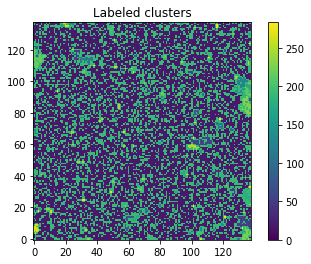

In [1076]:
b = arange(lw.max() + 1)
shuffle(b)
shuffledLw = b[lw]
imshow(shuffledLw, origin='lower', interpolation='nearest')
colorbar()
title("Labeled clusters")
show()

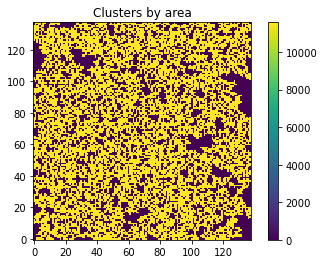

In [1077]:
area = measurements.sum(img, lw, index=arange(lw.max() + 1))
areaImg = area[lw]
im3 = imshow(areaImg, origin='lower', interpolation='nearest')
colorbar()
title("Clusters by area")
show()

# Cox

In [1078]:
data = C[["survival_time", "event"]]

In [1079]:
data["E"] = np.array(Es)
data["M"] = np.array(Ms)

/home/dimi/anaconda3/envs/fastai_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/dimi/anaconda3/envs/fastai_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [1080]:
data.head()

,survival_time,event,E,M
274,10.000000,0.0,2.5,6
374,8.436111,0.0,3.5,8
486,8.547222,0.0,3.0,7
455,9.550000,0.0,2.5,6
166,7.177778,0.0,2.5,6


In [1081]:
#import seaborn as sns

/home/dimi/anaconda3/envs/fastai_env/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 59.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/dimi/anaconda3/envs/fastai_env/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


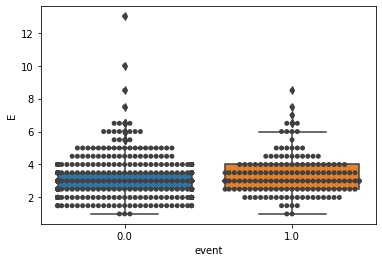

In [1082]:
sns.boxplot(x="event",   y="E", data=data);
sns.swarmplot(x="event", y="E", data=data, color=".25");

/home/dimi/anaconda3/envs/fastai_env/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 61.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/dimi/anaconda3/envs/fastai_env/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 11.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


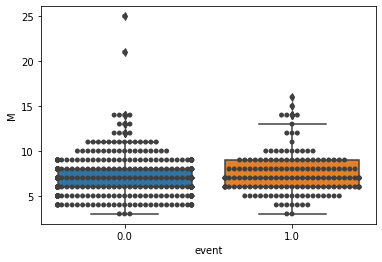

In [1083]:
sns.boxplot(x="event",   y="M", data=data);
sns.swarmplot(x="event", y="M", data=data, color=".25");

In [1084]:
dataa = pd.concat([C,data.drop(columns=["survival_time", "event"])], axis=1)

In [1085]:
# from lifelines import CoxPHFitter

In [1086]:
cph = CoxPHFitter()
# cph.fit(data.drop(columns=["E"]), duration_col='survival_time', event_col='event')
data_cox = dataa[["survival_time", "event", "E", "M", 
                  "grade", "node_status", "tumor_size"]]
data_cox = data_cox.dropna()
cph.fit(data_cox, duration_col='survival_time', event_col='event', 
        formula="M + grade + node_status + tumor_size")

<lifelines.CoxPHFitter: fitted with 636 total observations, 480 right-censored observations>

In [1087]:
cph.print_summary() 

<lifelines.CoxPHFitter: fitted with 636 total observations, 480 right-censored observations>
             duration col = 'survival_time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 636
number of events observed = 156
   partial log-likelihood = -941.12
         time fit was run = 2022-03-17 13:52:32 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
M                  0.02       1.03       0.03            -0.04             0.09                 0.97                 1.09
grade[T.2]         0.41       1.51       0.33            -0.23             1.05                 0.80                 2.87
grade[T.3]         0.91       2.49       0.32             0.28             1.55                 1.32                 4.69
node_status[T.1]   0.64       1.89       0.16             0.31             0.96                 1.37                 2.61
tumor_size         0.25       1.28       0.05             0.14             0.36                 1.15                 1.43

                    z      p   -log2(p)
covariate                              
M                0.81   0.42       1.25
grade[T.2]       1.26   0.21       2.27
grade[T.3]       2.81 <0.005       7.65
node_status[T.1] 3.87 <0.005      13.16
tumor_size       4.56 <0.005      17.58
---
Concordance = 0.69
Partial AIC = 1892.24
log-likelihood ratio test = 63.83 on 5 df
-log2(p) of ll-ratio test = 38.89

In [1003]:
cph.fit(data_cox, duration_col='survival_time', event_col='event', 
        formula="M")
cph.print_summary() 

<lifelines.CoxPHFitter: fitted with 636 total observations, 480 right-censored observations>
             duration col = 'survival_time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 636
number of events observed = 156
   partial log-likelihood = -971.18
         time fit was run = 2022-03-17 11:42:38 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
M           0.03       1.03       0.02            -0.00             0.06                 1.00                 1.07

             z    p   -log2(p)
covariate                     
M         1.91 0.06       4.15
---
Concordance = 0.54
Partial AIC = 1944.37
log-likelihood ratio test = 3.70 on 1 df
-log2(p) of ll-ratio test = 4.20

/home/dimi/anaconda3/envs/fastai_env/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 22.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


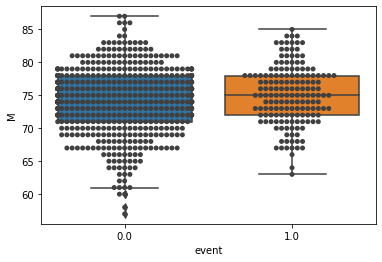

In [1004]:
sns.boxplot(x="event",   y="M", data=data);
sns.swarmplot(x="event", y="M", data=data, color=".25");

0.9355702583490864

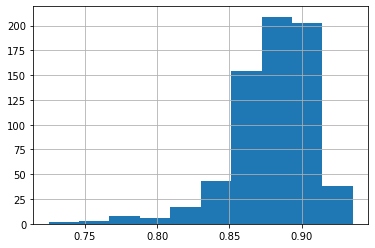

In [367]:
data["M"].hist()
data["M"].max()

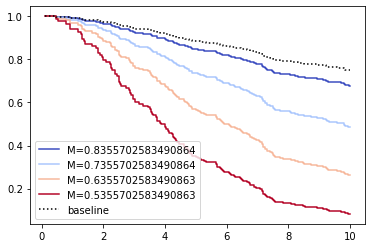

In [369]:
dm=0.1
cph.plot_partial_effects_on_outcome(covariates='M', values=[data["M"].max()-dm,
                                                           data["M"].max()-2*dm,
                                                           data["M"].max()-3*dm,
                                                           data["M"].max()-4*dm
                                                           ], cmap='coolwarm')